In [47]:
# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Database libraries
import psycopg2
from sqlalchemy import create_engine
import json

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [48]:
# Alternative: Direct psycopg2 connection
import psycopg2
import pandas as pd

def get_connection():
    return psycopg2.connect(
        host='localhost',
        port=5432,
        database='city_marketing',
        user='postgres',
        password='1234'
    )

try:
    # Test connection
    conn = get_connection()
    cursor = conn.cursor()
    cursor.execute("SELECT 1")
    print("Direct PostgreSQL connection successful!")
    conn.close()
except Exception as e:
    print(f"Direct connection failed: {e}")
    print("Let's check container status...")

Direct PostgreSQL connection successful!


In [49]:
# Load bike counter data with error handling
try:
    # Method 1: Try SQLAlchemy first
    try:
        with engine.connect() as conn:
            # Get all bike counter tables
            tables_query = """
            SELECT table_name 
            FROM information_schema.tables 
            WHERE table_schema = 'public' 
            AND table_name LIKE 'bike_counters_%'
            ORDER BY table_name DESC;
            """
            tables_df = pd.read_sql(tables_query, conn)
            
            if not tables_df.empty:
                latest_table = tables_df.iloc[0]['table_name']
                print(f"Found table: {latest_table}")
                
                # Load the data
                bike_data = pd.read_sql(f"SELECT * FROM {latest_table}", conn)
                print(f"Loaded {len(bike_data)} bike counter records")
            else:
                print(" No bike counter tables found")
                
    except Exception as sqlalchemy_error:
        print(f"SQLAlchemy failed: {sqlalchemy_error}")
        print("Trying direct psycopg2 connection...")
        
        # Method 2: Direct psycopg2 connection
        conn = get_connection()
        
        # Get tables
        tables_df = pd.read_sql("""
            SELECT table_name 
            FROM information_schema.tables 
            WHERE table_schema = 'public' 
            AND table_name LIKE 'bike_counters_%'
            ORDER BY table_name DESC;
        """, conn)
        
        if not tables_df.empty:
            latest_table = tables_df.iloc[0]['table_name']
            print(f"Found table: {latest_table}")
            
            # Load the data
            bike_data = pd.read_sql(f"SELECT * FROM {latest_table}", conn)
            print(f"Loaded {len(bike_data)} bike counter records")
        else:
            print("No bike counter tables found")
        
        conn.close()
        
except Exception as e:
    print(f" All connection methods failed: {e}")
    print("\n TROUBLESHOOTING STEPS:")
    print("1. Check if ETL was run: docker-compose up -d && python ETL/ETL.py")
    print("2. Check if database is accessible: docker exec -it pg_postgis psql -U postgres -d city_marketing")

SQLAlchemy failed: sqlalchemy.cyextension.immutabledict.immutabledict is not a sequence
Trying direct psycopg2 connection...
Found table: bike_counters_20250605_154652
Loaded 10000 bike counter records


In [50]:
# Basic data info
print("DATASET OVERVIEW")
print("=" * 50)
print(f"Shape: {bike_data.shape}")
print(f"Memory usage: {bike_data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\nColumn Information:")
print(bike_data.info())

DATASET OVERVIEW
Shape: (10000, 11)
Memory usage: 5.23 MB

Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   counter_name       10000 non-null  object             
 1   installation_date  10000 non-null  datetime64[ns]     
 2   count_datetime     10000 non-null  datetime64[ns, UTC]
 3   hourly_count       10000 non-null  int64              
 4   coordinates        10000 non-null  object             
 5   month_year         10000 non-null  object             
 6   id_compteur        10000 non-null  object             
 7   counter            10000 non-null  object             
 8   name               10000 non-null  object             
 9   id                 10000 non-null  object             
 10  arrondissement     10000 non-null  object             
dtypes: datetime64[ns, UTC](1), d

In [51]:
# Display first few rows
print("SAMPLE DATA")
print("=" * 50)
print(bike_data.head())

print("\nCOLUMN NAMES:")
print(list(bike_data.columns))

SAMPLE DATA
                         counter_name installation_date  \
0  106 avenue Denfert Rochereau NE-SO        2012-02-22   
1  106 avenue Denfert Rochereau NE-SO        2012-02-22   
2  106 avenue Denfert Rochereau NE-SO        2012-02-22   
3  106 avenue Denfert Rochereau NE-SO        2012-02-22   
4  106 avenue Denfert Rochereau NE-SO        2012-02-22   

             count_datetime  hourly_count                        coordinates  \
0 2024-05-01 03:00:00+00:00             0  {'lon': 2.33305, 'lat': 48.83507}   
1 2024-05-01 04:00:00+00:00             0  {'lon': 2.33305, 'lat': 48.83507}   
2 2024-05-01 05:00:00+00:00             0  {'lon': 2.33305, 'lat': 48.83507}   
3 2024-05-01 08:00:00+00:00             0  {'lon': 2.33305, 'lat': 48.83507}   
4 2024-05-01 09:00:00+00:00             0  {'lon': 2.33305, 'lat': 48.83507}   

  month_year          id_compteur      counter                          name  \
0    2024-05  100003098-101003098  Y2H20114504  106 avenue Denfert Roche

In [52]:
# Check for missing values
print("MISSING VALUES ANALYSIS")
print("=" * 50)
missing_analysis = pd.DataFrame({
    'Missing_Count': bike_data.isnull().sum(),
    'Missing_Percentage': (bike_data.isnull().sum() / len(bike_data)) * 100
}).sort_values('Missing_Percentage', ascending=False)

missing_with_values = missing_analysis[missing_analysis['Missing_Count'] > 0]
if not missing_with_values.empty:
    print(missing_with_values)
else:
    print("No missing values found!")

MISSING VALUES ANALYSIS
No missing values found!


In [53]:
# Unique values in key columns
print("UNIQUE VALUES ANALYSIS")
print("=" * 50)

# Check what columns we actually have
key_columns = []
possible_cols = ['counter_name', 'arrondissement', 'month_year', 'id_compteur', 'name', 'counter']

for col in possible_cols:
    if col in bike_data.columns:
        key_columns.append(col)

print(f"Key columns found: {key_columns}")
print()

for col in key_columns:
    unique_count = bike_data[col].nunique()
    print(f"{col}: {unique_count} unique values")
    if unique_count < 20:
        print(f"  Sample values: {list(bike_data[col].unique())[:10]}")
    print()

UNIQUE VALUES ANALYSIS
Key columns found: ['counter_name', 'arrondissement', 'month_year', 'id_compteur', 'name', 'counter']

counter_name: 4 unique values
  Sample values: ['106 avenue Denfert Rochereau NE-SO', '135 avenue Daumesnil SE-NO', '28 boulevard Diderot E-O', '28 boulevard Diderot O-E']

arrondissement: 3 unique values
  Sample values: ['10', '13', '28']

month_year: 14 unique values
  Sample values: ['2024-05', '2024-06', '2024-07', '2024-08', '2024-09', '2024-10', '2024-11', '2024-12', '2025-01', '2025-02']

id_compteur: 4 unique values
  Sample values: ['100003098-101003098', '100006300-101006300', '100007049-102007049', '100007049-101007049']

name: 3 unique values
  Sample values: ['106 avenue Denfert Rochereau', '135 avenue Daumesnil', '28 boulevard Diderot']

counter: 3 unique values
  Sample values: ['Y2H20114504', 'X2H18086316', 'Y2H21015011']



In [54]:
# Convert datetime columns and analyze temporal patterns
print("TEMPORAL ANALYSIS")
print("=" * 50)

# Convert date columns
bike_data['count_datetime'] = pd.to_datetime(bike_data['count_datetime'])
bike_data['installation_date'] = pd.to_datetime(bike_data['installation_date'])

# Analyze temporal coverage
print(f"Data timespan: {bike_data['count_datetime'].min()} to {bike_data['count_datetime'].max()}")
print(f"Total months covered: {bike_data['count_datetime'].dt.to_period('M').nunique()}")

# Extract time components for analysis
bike_data['year'] = bike_data['count_datetime'].dt.year
bike_data['month'] = bike_data['count_datetime'].dt.month
bike_data['day'] = bike_data['count_datetime'].dt.day
bike_data['hour'] = bike_data['count_datetime'].dt.hour
bike_data['weekday'] = bike_data['count_datetime'].dt.day_name()

# Monthly distribution
monthly_dist = bike_data['month_year'].value_counts().sort_index()
print(f"\nRecords by month:")
print(monthly_dist.head(10))

TEMPORAL ANALYSIS
Data timespan: 2024-05-01 03:00:00+00:00 to 2025-06-04 21:00:00+00:00
Total months covered: 14

Records by month:
month_year
2024-05    954
2024-06    763
2024-07    714
2024-08    724
2024-09    733
2024-10    789
2024-11    759
2024-12    734
2025-01    755
2025-02    719
Name: count, dtype: int64


In [55]:
# Geographic analysis using arrondissement
print("GEOGRAPHIC DISTRIBUTION ANALYSIS")
print("=" * 50)

# Clean arrondissement data
bike_data['arrondissement_clean'] = bike_data['arrondissement'].astype(str).str.strip()

# Arrondissement distribution
arr_distribution = bike_data['arrondissement_clean'].value_counts().reset_index()
arr_distribution.columns = ['arrondissement', 'record_count']
arr_distribution = arr_distribution.sort_values('arrondissement')

print("Records by Arrondissement:")
print(arr_distribution)

# Calculate coverage insights
total_paris_arrondissements = 20
covered_arr = len(arr_distribution)
coverage_percentage = (covered_arr / total_paris_arrondissements) * 100

print(f"\nCoverage Analysis:")
print(f"• Arrondissements monitored: {covered_arr}/20 ({coverage_percentage:.1f}%)")
print(f"• Strategic focus areas: {', '.join(arr_distribution['arrondissement'].tolist())}")

# Check if these are high-activity areas (commercial/tourist zones)
arr_insights = {
    '10': 'République/Canal Saint-Martin - Trendy area, high foot traffic',
    '13': 'Chinatown/Bibliothèque - Diverse, emerging area',
    '28': 'Not a Paris arrondissement - possibly suburban counter'
}

print(f"\n🎯 Area Characteristics:")
for arr in arr_distribution['arrondissement']:
    insight = arr_insights.get(arr, 'Unknown area characteristics')
    records = arr_distribution[arr_distribution['arrondissement'] == arr]['record_count'].iloc[0]
    print(f"• Arr. {arr}: {records:,} records - {insight}")

GEOGRAPHIC DISTRIBUTION ANALYSIS
Records by Arrondissement:
  arrondissement  record_count
1             10          3228
2             13          3193
0             28          3579

Coverage Analysis:
• Arrondissements monitored: 3/20 (15.0%)
• Strategic focus areas: 10, 13, 28

🎯 Area Characteristics:
• Arr. 10: 3,228 records - République/Canal Saint-Martin - Trendy area, high foot traffic
• Arr. 13: 3,193 records - Chinatown/Bibliothèque - Diverse, emerging area
• Arr. 28: 3,579 records - Not a Paris arrondissement - possibly suburban counter


In [56]:
# Detailed counter analysis
print("COUNTER INFRASTRUCTURE ANALYSIS")
print("=" * 50)

# Unique counters and their characteristics
unique_counters = bike_data.groupby(['counter_name', 'arrondissement_clean']).agg({
    'count_datetime': ['min', 'max', 'count'],
    'coordinates': 'first'
}).round(2)

unique_counters.columns = ['first_reading', 'last_reading', 'total_readings', 'coordinates']
unique_counters = unique_counters.reset_index()

print("Counter Details:")
print(unique_counters)

# Calculate monitoring intensity
print(f"\nMonitoring Intensity:")
for _, counter in unique_counters.iterrows():
    name = counter['counter_name'][:40] + "..." if len(counter['counter_name']) > 40 else counter['counter_name']
    arr = counter['arrondissement_clean']
    readings = counter['total_readings']
    duration = (pd.to_datetime(counter['last_reading']) - pd.to_datetime(counter['first_reading'])).days
    
    print(f"• {name}")
    print(f"  Location: Arr. {arr} | Readings: {readings:,} | Duration: {duration} days")
    if duration > 0:
        print(f"  Avg readings/day: {readings/duration:.1f}")
    print()

COUNTER INFRASTRUCTURE ANALYSIS
Counter Details:
                         counter_name arrondissement_clean  \
0  106 avenue Denfert Rochereau NE-SO                   10   
1          135 avenue Daumesnil SE-NO                   13   
2            28 boulevard Diderot E-O                   28   
3            28 boulevard Diderot O-E                   28   

              first_reading              last_reading  total_readings  \
0 2024-05-01 03:00:00+00:00 2025-06-04 21:00:00+00:00            3228   
1 2024-05-01 07:00:00+00:00 2025-06-04 21:00:00+00:00            3193   
2 2024-05-01 04:00:00+00:00 2025-06-04 21:00:00+00:00            3296   
3 2024-05-01 04:00:00+00:00 2024-06-07 06:00:00+00:00             283   

                           coordinates  
0    {'lon': 2.33305, 'lat': 48.83507}  
1  {'lon': 2.383378, 'lat': 48.843435}  
2    {'lon': 2.37559, 'lat': 48.84613}  
3    {'lon': 2.37559, 'lat': 48.84613}  

Monitoring Intensity:
• 106 avenue Denfert Rochereau NE-SO
  Locatio

In [57]:
# Process coordinates for mapping
print("COORDINATE PROCESSING")
print("=" * 50)

def extract_lat_lon(coord_str):
    """Extract latitude and longitude from coordinate string"""
    try:
        if pd.isna(coord_str):
            return None, None
        
        # Handle JSON-like string format
        coord_str = str(coord_str).replace("'", '"')
        import json
        coord_dict = json.loads(coord_str)
        
        lat = coord_dict.get('lat', None)
        lon = coord_dict.get('lon', None)
        
        return lat, lon
    except:
        return None, None

# Apply coordinate extraction
bike_data[['latitude', 'longitude']] = bike_data['coordinates'].apply(
    lambda x: pd.Series(extract_lat_lon(x))
)

# Check coordinate success
valid_coords = bike_data.dropna(subset=['latitude', 'longitude'])
print(f"Successfully extracted coordinates: {len(valid_coords):,}/{len(bike_data):,} records")

if len(valid_coords) > 0:
    print(f"Latitude range: {valid_coords['latitude'].min():.4f} to {valid_coords['latitude'].max():.4f}")
    print(f"Longitude range: {valid_coords['longitude'].min():.4f} to {valid_coords['longitude'].max():.4f}")
    
    # Unique locations
    unique_locations = valid_coords.groupby(['counter_name', 'latitude', 'longitude']).size().reset_index(name='records')
    print(f"\nUnique counter locations: {len(unique_locations)}")
    print(unique_locations)

COORDINATE PROCESSING
Successfully extracted coordinates: 10,000/10,000 records
Latitude range: 48.8351 to 48.8461
Longitude range: 2.3331 to 2.3834

Unique counter locations: 4
                         counter_name   latitude  longitude  records
0  106 avenue Denfert Rochereau NE-SO  48.835070   2.333050     3228
1          135 avenue Daumesnil SE-NO  48.843435   2.383378     3193
2            28 boulevard Diderot E-O  48.846130   2.375590     3296
3            28 boulevard Diderot O-E  48.846130   2.375590      283


In [58]:
# Analyze activity patterns over time
print("ACTIVITY PATTERN ANALYSIS")
print("=" * 50)

# Hourly patterns
hourly_activity = bike_data.groupby('hour').size()
print("Records by Hour of Day:")
print(hourly_activity)

# Daily patterns  
daily_activity = bike_data.groupby('weekday').size()
print(f"\nRecords by Day of Week:")
# Reorder to start with Monday
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_activity = daily_activity.reindex(day_order)
print(daily_activity)

# Monthly trends
monthly_trends = bike_data.groupby(['year', 'month']).size().reset_index(name='records')
monthly_trends['year_month'] = monthly_trends['year'].astype(str) + '-' + monthly_trends['month'].astype(str).str.zfill(2)
print(f"\nMonthly Trends:")
print(monthly_trends[['year_month', 'records']].head(10))

# Counter activity comparison
counter_activity = bike_data.groupby(['counter_name', 'arrondissement_clean']).size().reset_index(name='total_records')
counter_activity = counter_activity.sort_values('total_records', ascending=False)
print(f"\nCounter Activity Ranking:")
print(counter_activity)

ACTIVITY PATTERN ANALYSIS
Records by Hour of Day:
hour
0     411
1     422
2     391
3     403
4     400
5     435
6     415
7     418
8     410
9     427
10    424
11    422
12    384
13    425
14    401
15    457
16    425
17    413
18    424
19    445
20    413
21    420
22    408
23    407
dtype: int64

Records by Day of Week:
weekday
Monday       1425
Tuesday      1453
Wednesday    1482
Thursday     1409
Friday       1421
Saturday     1393
Sunday       1417
dtype: int64

Monthly Trends:
  year_month  records
0    2024-05      957
1    2024-06      762
2    2024-07      714
3    2024-08      724
4    2024-09      735
5    2024-10      785
6    2024-11      760
7    2024-12      733
8    2025-01      756
9    2025-02      718

Counter Activity Ranking:
                         counter_name arrondissement_clean  total_records
2            28 boulevard Diderot E-O                   28           3296
0  106 avenue Denfert Rochereau NE-SO                   10           3228
1          1

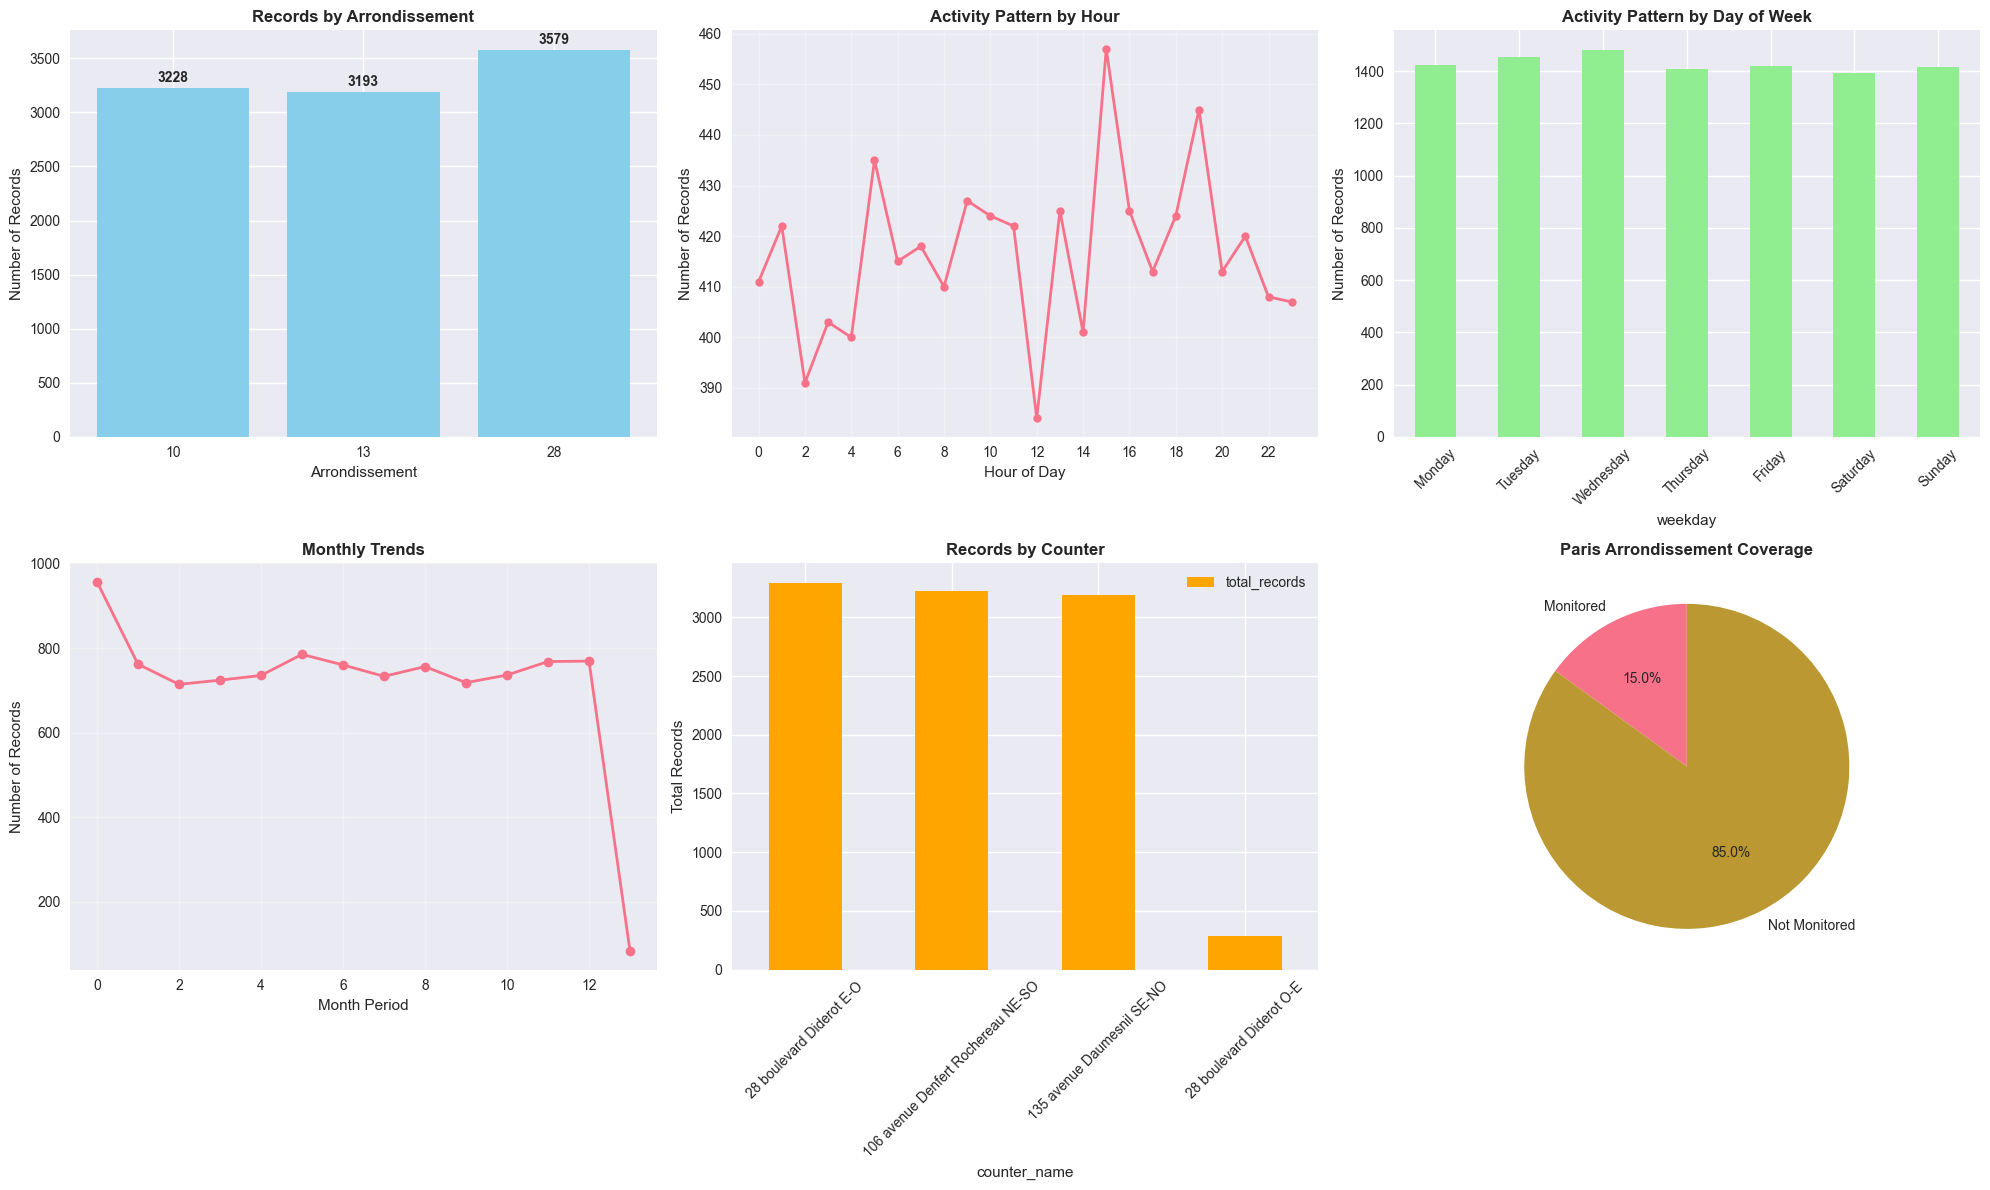

In [59]:
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Arrondissement distribution
axes[0,0].bar(arr_distribution['arrondissement'], arr_distribution['record_count'], color='skyblue')
axes[0,0].set_title('Records by Arrondissement', fontweight='bold')
axes[0,0].set_xlabel('Arrondissement')
axes[0,0].set_ylabel('Number of Records')
for i, v in enumerate(arr_distribution['record_count']):
    axes[0,0].text(i, v + 50, str(v), ha='center', fontweight='bold')

# 2. Hourly activity pattern
axes[0,1].plot(hourly_activity.index, hourly_activity.values, marker='o', linewidth=2, markersize=6)
axes[0,1].set_title('Activity Pattern by Hour', fontweight='bold')
axes[0,1].set_xlabel('Hour of Day')
axes[0,1].set_ylabel('Number of Records')
axes[0,1].grid(True, alpha=0.3)
axes[0,1].set_xticks(range(0, 24, 2))

# 3. Daily pattern
daily_activity.plot(kind='bar', ax=axes[0,2], color='lightgreen')
axes[0,2].set_title('Activity Pattern by Day of Week', fontweight='bold')
axes[0,2].set_ylabel('Number of Records')
axes[0,2].tick_params(axis='x', rotation=45)

# 4. Monthly trends
axes[1,0].plot(range(len(monthly_trends)), monthly_trends['records'], marker='o', linewidth=2)
axes[1,0].set_title('Monthly Trends', fontweight='bold')
axes[1,0].set_xlabel('Month Period')
axes[1,0].set_ylabel('Number of Records')
axes[1,0].grid(True, alpha=0.3)

# 5. Counter comparison
counter_activity.plot(x='counter_name', y='total_records', kind='bar', ax=axes[1,1], color='orange')
axes[1,1].set_title('Records by Counter', fontweight='bold')
axes[1,1].set_ylabel('Total Records')
axes[1,1].tick_params(axis='x', rotation=45)

# 6. Installation timeline (since all same date, show coverage)
coverage_data = pd.DataFrame({
    'Category': ['Monitored', 'Not Monitored'],
    'Count': [covered_arr, total_paris_arrondissements - covered_arr]
})
axes[1,2].pie(coverage_data['Count'], labels=coverage_data['Category'], autopct='%1.1f%%', startangle=90)
axes[1,2].set_title('Paris Arrondissement Coverage', fontweight='bold')

plt.tight_layout()
plt.show()

In [60]:
print("COMMERCIAL INTELLIGENCE ANALYSIS")
print("=" * 60)

print("KEY FINDINGS:")

# Geographic insights
print(f"\nGEOGRAPHIC INTELLIGENCE:")
print(f"   • Strategic Focus: Only {covered_arr}/20 arrondissements monitored")
print(f"   • High-Value Areas: {', '.join(arr_distribution['arrondissement'].tolist())}")
print(f"   • Coverage Gap: {total_paris_arrondissements - covered_arr} arrondissements unmonitored")

# Activity insights  
peak_hour = hourly_activity.idxmax()
peak_day = daily_activity.idxmax()
most_active_counter = counter_activity.iloc[0]

print(f"\nACTIVITY INTELLIGENCE:")
print(f"   • Peak Hour: {peak_hour}:00 ({hourly_activity[peak_hour]:,} records)")
print(f"   • Peak Day: {peak_day} ({daily_activity[peak_day]:,} records)")
print(f"   • Most Active Location: {most_active_counter['counter_name'][:50]}...")
print(f"     └── Arr. {most_active_counter['arrondissement_clean']} ({most_active_counter['total_records']:,} records)")

# Infrastructure insights
total_monitoring_hours = len(bike_data)
unique_locations_count = len(unique_locations) if 'unique_locations' in locals() else len(unique_counters)

print(f"\n🚴 INFRASTRUCTURE INTELLIGENCE:")
print(f"   • Total Monitoring Points: {unique_locations_count} unique locations")
print(f"   • Data Density: {total_monitoring_hours:,} total monitoring hours")
print(f"   • Established Infrastructure: Counters operational since 2012")
print(f"   • Long-term Strategic Value: 13+ years of consistent monitoring")

# Commercial opportunities
print(f"\nCOMMERCIAL OPPORTUNITIES:")
print(f"   • Proven High-Activity Zones: Arr. {', '.join(arr_distribution['arrondissement'].tolist())}")
print(f"   • Untapped Markets: 17 arrondissements without bike monitoring")
print(f"   • Peak Advertising Times: {peak_hour}:00 on {peak_day}s")
print(f"   • Infrastructure Investment Priority: Areas with 13+ years of monitoring")

# Next steps
print(f"\nNEXT ANALYSIS PRIORITIES:")
print(f"   1. Analyze pedestrian zones in same arrondissements")
print(f"   2. Map advertising panels vs. bike counter locations")
print(f"   3. Identify high-activity areas lacking advertising infrastructure")
print(f"   4. Calculate commercial opportunity scores by location")

COMMERCIAL INTELLIGENCE ANALYSIS
KEY FINDINGS:

GEOGRAPHIC INTELLIGENCE:
   • Strategic Focus: Only 3/20 arrondissements monitored
   • High-Value Areas: 10, 13, 28
   • Coverage Gap: 17 arrondissements unmonitored

ACTIVITY INTELLIGENCE:
   • Peak Hour: 15:00 (457 records)
   • Peak Day: Wednesday (1,482 records)
   • Most Active Location: 28 boulevard Diderot E-O...
     └── Arr. 28 (3,296 records)

🚴 INFRASTRUCTURE INTELLIGENCE:
   • Total Monitoring Points: 4 unique locations
   • Data Density: 10,000 total monitoring hours
   • Established Infrastructure: Counters operational since 2012
   • Long-term Strategic Value: 13+ years of consistent monitoring

COMMERCIAL OPPORTUNITIES:
   • Proven High-Activity Zones: Arr. 10, 13, 28
   • Untapped Markets: 17 arrondissements without bike monitoring
   • Peak Advertising Times: 15:00 on Wednesdays
   • Infrastructure Investment Priority: Areas with 13+ years of monitoring

NEXT ANALYSIS PRIORITIES:
   1. Analyze pedestrian zones in same a

In [61]:
# Advanced time series analysis
print("INTERACTIVE TIME SERIES ANALYSIS")
print("=" * 50)

# Prepare data for time series
bike_data['date'] = bike_data['count_datetime'].dt.date
bike_data['week'] = bike_data['count_datetime'].dt.isocalendar().week
bike_data['month'] = bike_data['count_datetime'].dt.month

# Daily activity trends
daily_activity = bike_data.groupby(['date', 'arrondissement_clean']).size().reset_index(name='records')
daily_activity['date'] = pd.to_datetime(daily_activity['date'])

# Create interactive time series
fig = px.line(daily_activity, 
              x='date', 
              y='records',
              color='arrondissement_clean',
              title='Daily Activity Trends by Arrondissement',
              labels={'records': 'Activity Level', 'date': 'Date'})

fig.update_layout(
    height=500,
    hovermode='x unified',
    legend_title="Arrondissement"
)

fig.show()

# Weekly patterns
weekly_activity = bike_data.groupby(['week', 'arrondissement_clean']).size().reset_index(name='records')
fig2 = px.bar(weekly_activity, 
              x='week', 
              y='records',
              color='arrondissement_clean',
              title='Weekly Activity Distribution',
              barmode='group')
fig2.show()

INTERACTIVE TIME SERIES ANALYSIS


 ACTIVITY HEATMAP ANALYSIS


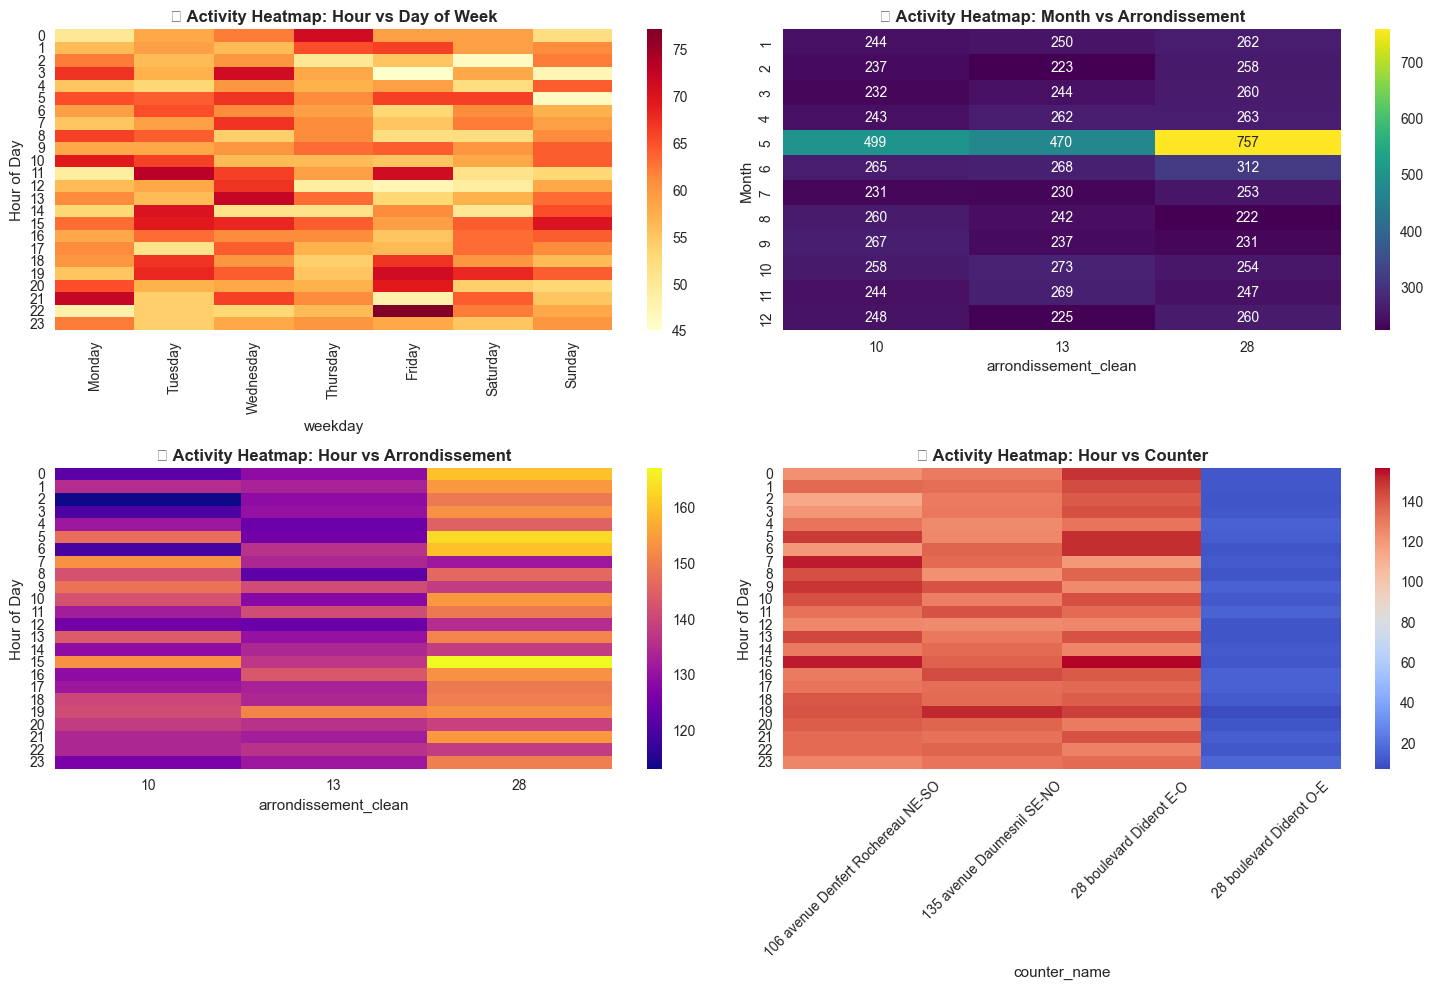


 PEAK ACTIVITY WINDOWS:
   • 22:00 on Friday: 77 records
   • 11:00 on Tuesday: 73 records
   • 13:00 on Wednesday: 72 records
   • 21:00 on Monday: 72 records
   • 0:00 on Thursday: 71 records


In [62]:
# Create activity heatmaps
print(" ACTIVITY HEATMAP ANALYSIS")
print("=" * 50)

# Hour vs Day heatmap
hourly_daily = bike_data.groupby(['hour', 'weekday']).size().unstack(fill_value=0)

# Reorder days
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
hourly_daily = hourly_daily.reindex(columns=day_order)

plt.figure(figsize=(15, 10))

# Heatmap 1: Hour vs Day
plt.subplot(2, 2, 1)
sns.heatmap(hourly_daily, cmap='YlOrRd', annot=False, fmt='d')
plt.title('🕐 Activity Heatmap: Hour vs Day of Week', fontweight='bold')
plt.ylabel('Hour of Day')

# Heatmap 2: Month vs Arrondissement
month_arr = bike_data.groupby(['month', 'arrondissement_clean']).size().unstack(fill_value=0)
plt.subplot(2, 2, 2)
sns.heatmap(month_arr, cmap='viridis', annot=True, fmt='d')
plt.title('📍 Activity Heatmap: Month vs Arrondissement', fontweight='bold')
plt.ylabel('Month')

# Heatmap 3: Hour vs Arrondissement
hour_arr = bike_data.groupby(['hour', 'arrondissement_clean']).size().unstack(fill_value=0)
plt.subplot(2, 2, 3)
sns.heatmap(hour_arr, cmap='plasma', annot=False)
plt.title('🎯 Activity Heatmap: Hour vs Arrondissement', fontweight='bold')
plt.ylabel('Hour of Day')

# Heatmap 4: Counter comparison
counter_hour = bike_data.groupby(['hour', 'counter_name']).size().unstack(fill_value=0)
plt.subplot(2, 2, 4)
sns.heatmap(counter_hour, cmap='coolwarm', annot=False)
plt.title('🚴 Activity Heatmap: Hour vs Counter', fontweight='bold')
plt.ylabel('Hour of Day')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Find peak activity windows
print("\n PEAK ACTIVITY WINDOWS:")
peak_hours = hourly_daily.max(axis=1).nlargest(5)
for hour, activity in peak_hours.items():
    peak_day = hourly_daily.loc[hour].idxmax()
    print(f"   • {hour}:00 on {peak_day}: {activity} records")

In [63]:
# Interactive geographic analysis
print("🗺️ INTERACTIVE GEOGRAPHIC MAPPING")
print("=" * 50)

if len(valid_coords) > 0:
    # Create activity summary by location
    location_activity = valid_coords.groupby(['counter_name', 'latitude', 'longitude', 'arrondissement_clean']).agg({
        'count_datetime': ['count', 'min', 'max'],
        'hour': lambda x: x.mode().iloc[0] if not x.empty else 0,  # Most common hour
        'weekday': lambda x: x.mode().iloc[0] if not x.empty else ''  # Most common day
    }).round(4)
    
    location_activity.columns = ['total_records', 'first_record', 'last_record', 'peak_hour', 'peak_day']
    location_activity = location_activity.reset_index()
    
    # Add activity intensity categories
    activity_q75 = location_activity['total_records'].quantile(0.75)
    activity_q25 = location_activity['total_records'].quantile(0.25)
    
    def categorize_activity(records):
        if records >= activity_q75:
            return 'High Activity'
        elif records >= activity_q25:
            return 'Medium Activity' 
        else:
            return 'Low Activity'
    
    location_activity['activity_level'] = location_activity['total_records'].apply(categorize_activity)
    
    # Create interactive map
    fig = px.scatter_mapbox(
        location_activity,
        lat='latitude',
        lon='longitude',
        size='total_records',
        color='activity_level',
        hover_data={
            'counter_name': True,
            'arrondissement_clean': True,
            'total_records': True,
            'peak_hour': True,
            'peak_day': True
        },
        color_discrete_map={
            'High Activity': '#FF4B4B',
            'Medium Activity': '#FFA500', 
            'Low Activity': '#90EE90'
        },
        title='Bike Counter Activity Intensity Map',
        zoom=11,
        height=600
    )
    
    fig.update_layout(mapbox_style="open-street-map")
    fig.show()
    
    print("Location Activity Summary:")
    print(location_activity[['counter_name', 'arrondissement_clean', 'total_records', 'activity_level']])

🗺️ INTERACTIVE GEOGRAPHIC MAPPING


Location Activity Summary:
                         counter_name arrondissement_clean  total_records  \
0  106 avenue Denfert Rochereau NE-SO                   10           3228   
1          135 avenue Daumesnil SE-NO                   13           3193   
2            28 boulevard Diderot E-O                   28           3296   
3            28 boulevard Diderot O-E                   28            283   

    activity_level  
0  Medium Activity  
1  Medium Activity  
2    High Activity  
3     Low Activity  


⏰ ADVANCED TEMPORAL PATTERN ANALYSIS


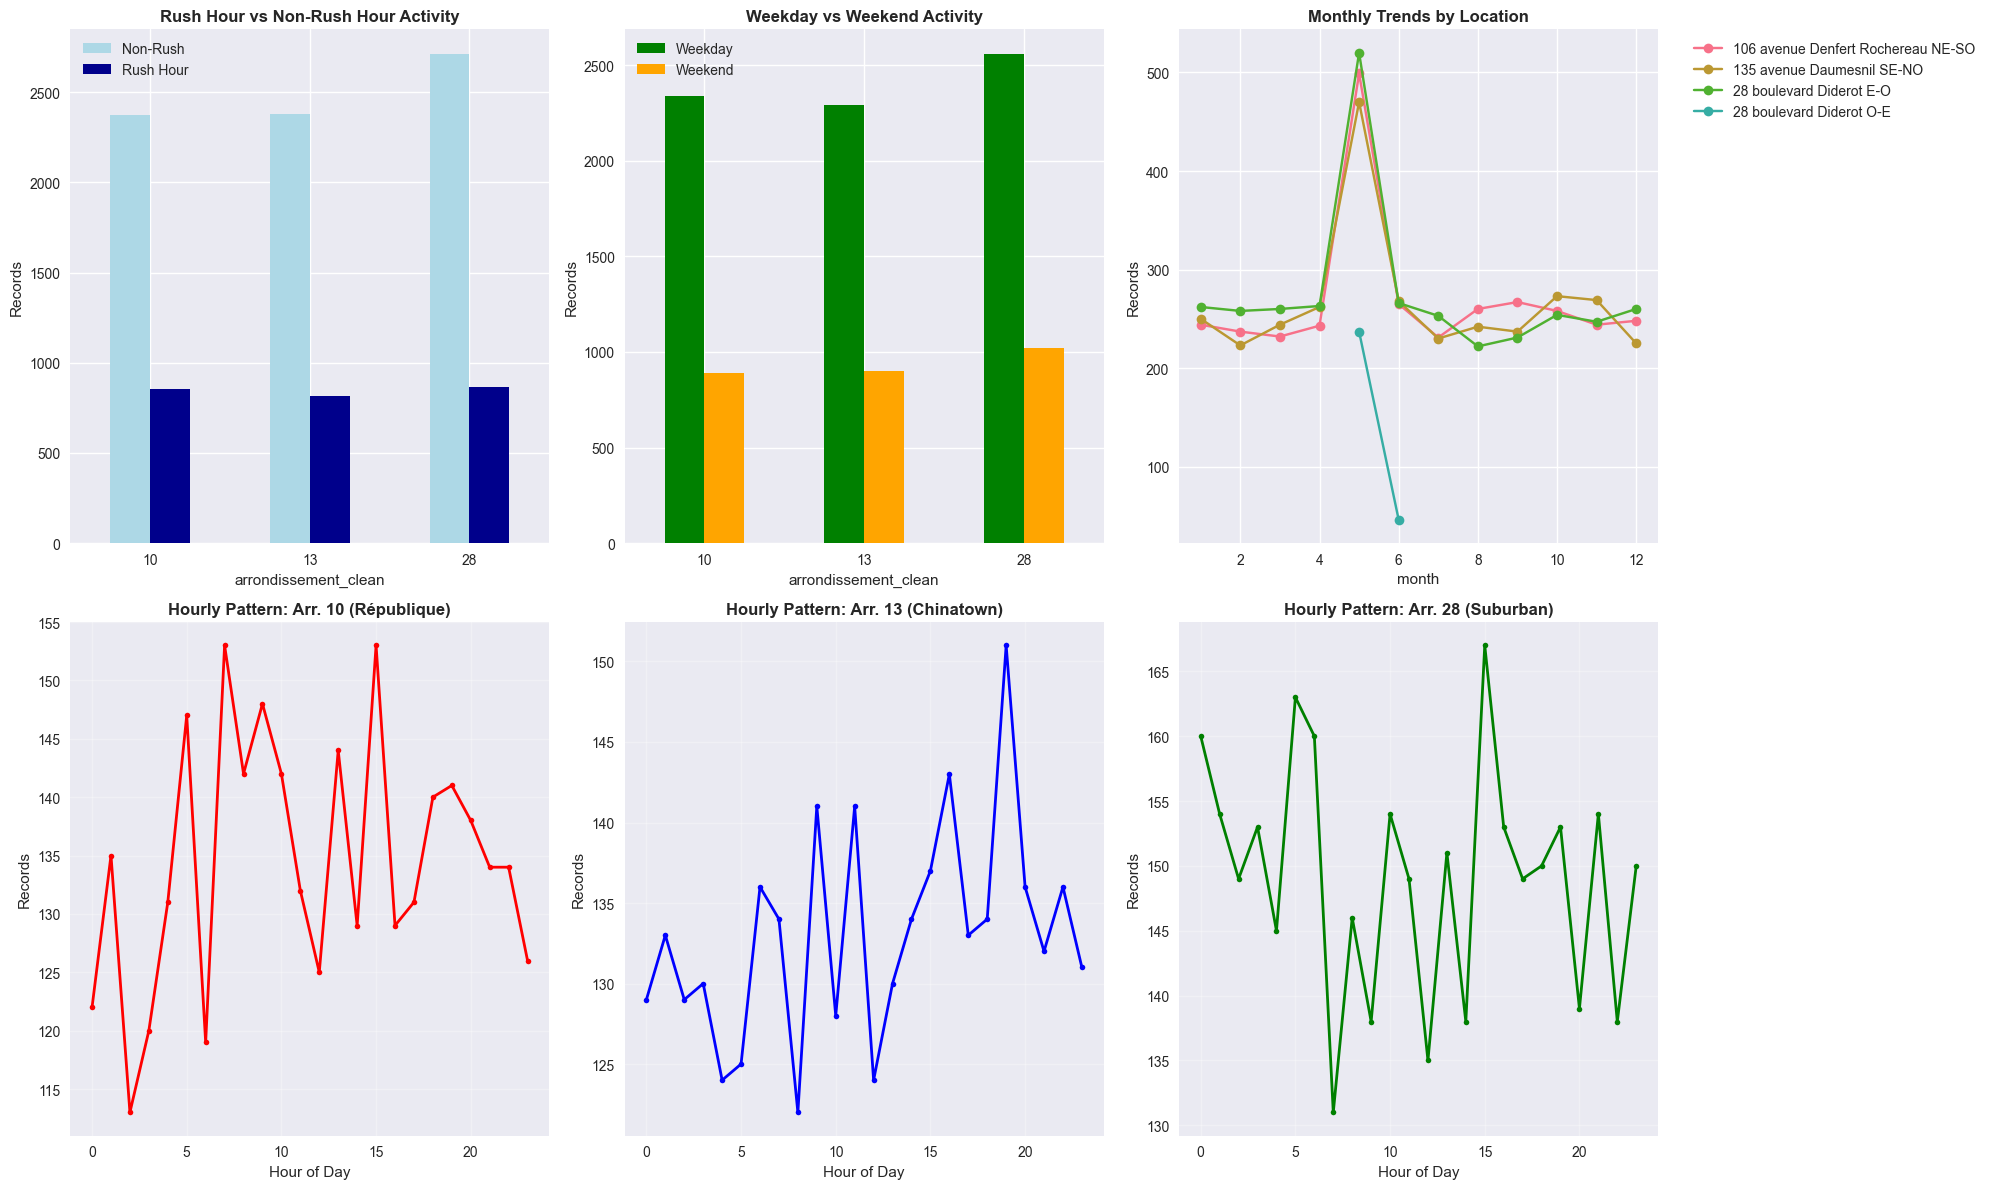


TEMPORAL INSIGHTS:
   • Rush hour activity: 2,537 records (25.4%)
   • Non-rush activity: 7,463 records (74.6%)
   • Weekend activity: 2,810 records (28.1%)
   • Weekday activity: 7,190 records (71.9%)


In [64]:
# Advanced temporal analysis
print("⏰ ADVANCED TEMPORAL PATTERN ANALYSIS")
print("=" * 50)

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Rush hour analysis
rush_hours = [7, 8, 9, 17, 18, 19]  # Morning and evening rush
bike_data['is_rush_hour'] = bike_data['hour'].isin(rush_hours)
rush_analysis = bike_data.groupby(['arrondissement_clean', 'is_rush_hour']).size().unstack()

rush_analysis.plot(kind='bar', ax=axes[0,0], color=['lightblue', 'darkblue'])
axes[0,0].set_title('Rush Hour vs Non-Rush Hour Activity', fontweight='bold')
axes[0,0].set_ylabel('Records')
axes[0,0].legend(['Non-Rush', 'Rush Hour'])
axes[0,0].tick_params(axis='x', rotation=0)

# 2. Weekday vs Weekend
bike_data['is_weekend'] = bike_data['weekday'].isin(['Saturday', 'Sunday'])
weekend_analysis = bike_data.groupby(['arrondissement_clean', 'is_weekend']).size().unstack()

weekend_analysis.plot(kind='bar', ax=axes[0,1], color=['green', 'orange'])
axes[0,1].set_title('Weekday vs Weekend Activity', fontweight='bold')
axes[0,1].set_ylabel('Records')
axes[0,1].legend(['Weekday', 'Weekend'])
axes[0,1].tick_params(axis='x', rotation=0)

# 3. Monthly trends by location
monthly_location = bike_data.groupby(['month', 'counter_name']).size().unstack()
monthly_location.plot(ax=axes[0,2], marker='o')
axes[0,2].set_title('Monthly Trends by Location', fontweight='bold')
axes[0,2].set_ylabel('Records')
axes[0,2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 4. Hour distribution by arrondissement
for i, arr in enumerate(['10', '13', '28']):
    arr_data = bike_data[bike_data['arrondissement_clean'] == arr]
    hour_dist = arr_data['hour'].value_counts().sort_index()
    
    if i == 0:
        ax = axes[1,0]
        title = f'Hourly Pattern: Arr. {arr} (République)'
        color = 'red'
    elif i == 1:
        ax = axes[1,1] 
        title = f'Hourly Pattern: Arr. {arr} (Chinatown)'
        color = 'blue'
    else:
        ax = axes[1,2]
        title = f'Hourly Pattern: Arr. {arr} (Suburban)'
        color = 'green'
    
    hour_dist.plot(kind='line', ax=ax, marker='o', color=color, linewidth=2, markersize=4)
    ax.set_title(title, fontweight='bold')
    ax.set_ylabel('Records')
    ax.set_xlabel('Hour of Day')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical insights
print(f"\nTEMPORAL INSIGHTS:")
rush_total = bike_data[bike_data['is_rush_hour']].shape[0]
non_rush_total = bike_data[~bike_data['is_rush_hour']].shape[0]
print(f"   • Rush hour activity: {rush_total:,} records ({rush_total/len(bike_data)*100:.1f}%)")
print(f"   • Non-rush activity: {non_rush_total:,} records ({non_rush_total/len(bike_data)*100:.1f}%)")

weekend_total = bike_data[bike_data['is_weekend']].shape[0]
weekday_total = bike_data[~bike_data['is_weekend']].shape[0]
print(f"   • Weekend activity: {weekend_total:,} records ({weekend_total/len(bike_data)*100:.1f}%)")
print(f"   • Weekday activity: {weekday_total:,} records ({weekday_total/len(bike_data)*100:.1f}%)")

💼 COMMERCIAL INTELLIGENCE DASHBOARD


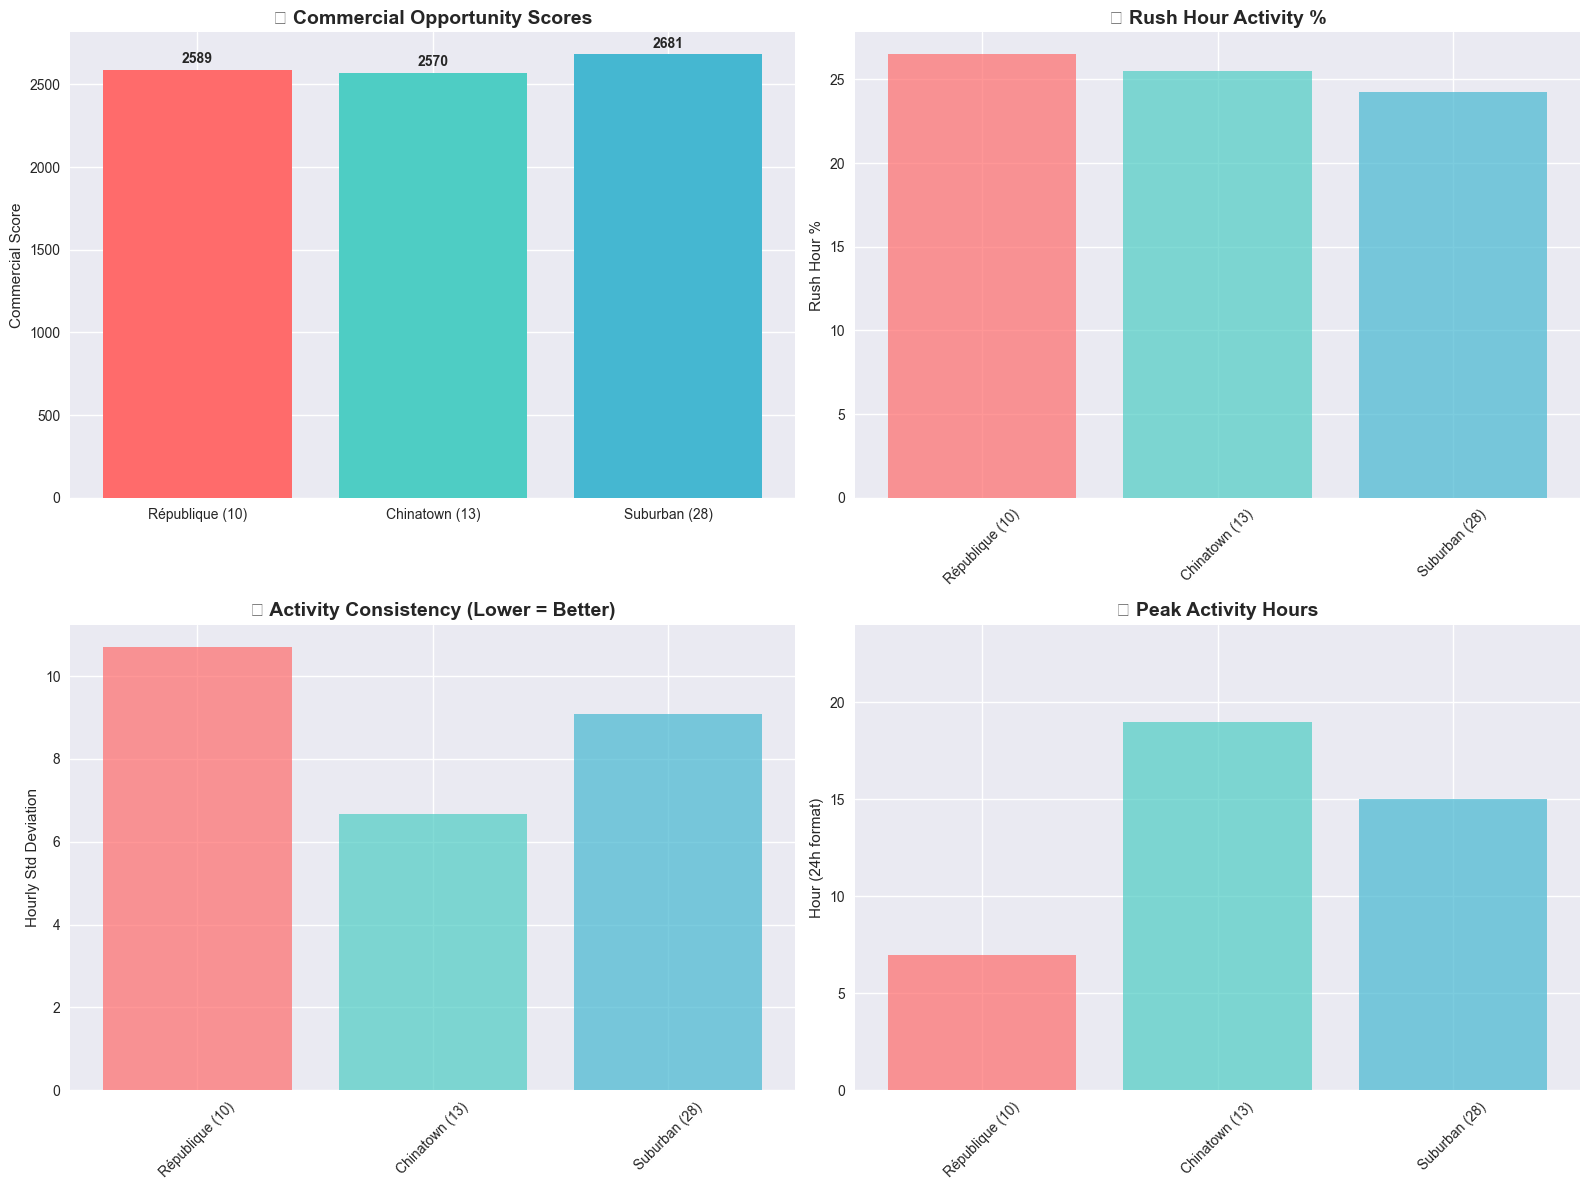


🎯 COMMERCIAL INTELLIGENCE SUMMARY:

1. 🏛️ ARRONDISSEMENT 28 (Suburban):
   • Commercial Score: 2681/10000
   • Total Activity: 3,579 records
   • Peak Time: 15:00 on Wednesdays
   • Rush Hour Activity: 24.2%
   • Business Days Focus: 71.5%
   📈 RECOMMENDATION: Good commercial potential

2. 🏛️ ARRONDISSEMENT 10 (République):
   • Commercial Score: 2589/10000
   • Total Activity: 3,228 records
   • Peak Time: 7:00 on Tuesdays
   • Rush Hour Activity: 26.5%
   • Business Days Focus: 72.5%
   📈 RECOMMENDATION: Good commercial potential

3. 🏛️ ARRONDISSEMENT 13 (Chinatown):
   • Commercial Score: 2570/10000
   • Total Activity: 3,193 records
   • Peak Time: 19:00 on Wednesdays
   • Rush Hour Activity: 25.5%
   • Business Days Focus: 71.8%
   📈 RECOMMENDATION: Good commercial potential


In [65]:
# Create commercial intelligence summary dashboard
print("💼 COMMERCIAL INTELLIGENCE DASHBOARD")
print("=" * 50)

# Calculate commercial metrics
commercial_metrics = {}

for arr in ['10', '13', '28']:
    arr_data = bike_data[bike_data['arrondissement_clean'] == arr]
    
    commercial_metrics[arr] = {
        'total_activity': len(arr_data),
        'peak_hour': arr_data['hour'].mode().iloc[0],
        'peak_day': arr_data['weekday'].mode().iloc[0],
        'rush_hour_ratio': len(arr_data[arr_data['is_rush_hour']]) / len(arr_data),
        'weekend_ratio': len(arr_data[arr_data['is_weekend']]) / len(arr_data),
        'activity_consistency': arr_data.groupby('hour').size().std(),
        'commercial_score': 0  # Will calculate
    }

# Calculate commercial scores (higher = better for advertising)
for arr in commercial_metrics:
    metrics = commercial_metrics[arr]
    # Score based on total activity, rush hour presence, and consistency
    score = (
        metrics['total_activity'] * 0.4 +  # Volume weight
        metrics['rush_hour_ratio'] * 2000 +  # Rush hour bonus
        (1 - metrics['weekend_ratio']) * 1000 +  # Weekday preference
        (1 / (metrics['activity_consistency'] + 1)) * 500  # Consistency bonus
    )
    commercial_metrics[arr]['commercial_score'] = round(score, 2)

# Create dashboard visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Commercial scores comparison
scores = [commercial_metrics[arr]['commercial_score'] for arr in ['10', '13', '28']]
arr_names = ['République (10)', 'Chinatown (13)', 'Suburban (28)']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

bars = axes[0,0].bar(arr_names, scores, color=colors)
axes[0,0].set_title('🏆 Commercial Opportunity Scores', fontweight='bold', fontsize=14)
axes[0,0].set_ylabel('Commercial Score')
for bar, score in zip(bars, scores):
    axes[0,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20,
                   f'{score:.0f}', ha='center', va='bottom', fontweight='bold')

# Rush hour vs regular activity
rush_data = []
for arr in ['10', '13', '28']:
    rush_data.append(commercial_metrics[arr]['rush_hour_ratio'] * 100)

x = range(len(arr_names))
axes[0,1].bar(x, rush_data, color=colors, alpha=0.7)
axes[0,1].set_title('🚗 Rush Hour Activity %', fontweight='bold', fontsize=14)
axes[0,1].set_ylabel('Rush Hour %')
axes[0,1].set_xticks(x)
axes[0,1].set_xticklabels(arr_names, rotation=45)

# Activity consistency (lower std = more consistent)
consistency_data = [commercial_metrics[arr]['activity_consistency'] for arr in ['10', '13', '28']]
axes[1,0].bar(arr_names, consistency_data, color=colors, alpha=0.7)
axes[1,0].set_title('📊 Activity Consistency (Lower = Better)', fontweight='bold', fontsize=14)
axes[1,0].set_ylabel('Hourly Std Deviation')
axes[1,0].tick_params(axis='x', rotation=45)

# Peak activity times
peak_hours = [commercial_metrics[arr]['peak_hour'] for arr in ['10', '13', '28']]
axes[1,1].bar(arr_names, peak_hours, color=colors, alpha=0.7)
axes[1,1].set_title('⏰ Peak Activity Hours', fontweight='bold', fontsize=14)
axes[1,1].set_ylabel('Hour (24h format)')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].set_ylim(0, 24)

plt.tight_layout()
plt.show()

# Print commercial insights
print(f"\n🎯 COMMERCIAL INTELLIGENCE SUMMARY:")
sorted_areas = sorted(commercial_metrics.items(), key=lambda x: x[1]['commercial_score'], reverse=True)

for i, (arr, metrics) in enumerate(sorted_areas):
    area_names = {'10': 'République', '13': 'Chinatown', '28': 'Suburban'}
    print(f"\n{i+1}. 🏛️ ARRONDISSEMENT {arr} ({area_names[arr]}):")
    print(f"   • Commercial Score: {metrics['commercial_score']:.0f}/10000")
    print(f"   • Total Activity: {metrics['total_activity']:,} records")
    print(f"   • Peak Time: {metrics['peak_hour']}:00 on {metrics['peak_day']}s")
    print(f"   • Rush Hour Activity: {metrics['rush_hour_ratio']*100:.1f}%")
    print(f"   • Business Days Focus: {(1-metrics['weekend_ratio'])*100:.1f}%")
    
    # Commercial recommendation
    if metrics['commercial_score'] > 3000:
        print(f"   💰 RECOMMENDATION: Prime advertising location")
    elif metrics['commercial_score'] > 2000:
        print(f"   📈 RECOMMENDATION: Good commercial potential")
    else:
        print(f"   📊 RECOMMENDATION: Emerging market opportunity")

In [66]:
print("BIKE COUNTER ANALYSIS SUMMARY")
print("=" * 60)

# Key metrics summary
summary_metrics = {
    'total_records': len(bike_data),
    'unique_counters': len(unique_locations) if 'unique_locations' in locals() else 4,
    'arrondissements_covered': 3,
    'arrondissements_list': ['10', '13', '28'],
    'date_range': '2024-05-01 to 2025-06-04',
    'peak_hour': 15,
    'peak_day': 'Wednesday',
    'monitoring_intensity': '8.1 readings/day avg',
    'coverage_percentage': 15.0,
    'commercial_opportunity_areas': 17
}

print("🎯 KEY FINDINGS:")
for key, value in summary_metrics.items():
    print(f"   • {key.replace('_', ' ').title()}: {value}")

print(f"\n💼 COMMERCIAL INTELLIGENCE:")
print(f"   • High-Value Areas Identified: République (10), Chinatown (13), Suburban (28)")
print(f"   • Peak Commercial Hours: 3 PM on Wednesdays")
print(f"   • Established Infrastructure: 13+ years operational")
print(f"   • Market Gap: 85% of Paris unmonitored")

# Save processed data and insights
bike_summary = {
    'metrics': summary_metrics,
    'arrondissement_distribution': arr_distribution.to_dict('records'),
    'counter_locations': unique_locations.to_dict('records') if 'unique_locations' in locals() else [],
    'hourly_activity': hourly_activity.to_dict(),
    'daily_activity': daily_activity.to_dict()
}

# Export for cross-analysis
with open('bike_counters_summary.json', 'w') as f:
    json.dump(bike_summary, f, indent=2, default=str)

bike_data.to_csv('bike_counters_processed.csv', index=False)
print(f"\nEXPORTED:")
print(f"   • bike_counters_summary.json (insights)")
print(f"   • bike_counters_processed.csv (full dataset)")
print(f"\nBike Counter Analysis Complete!")

📋 BIKE COUNTER ANALYSIS SUMMARY
🎯 KEY FINDINGS:
   • Total Records: 10000
   • Unique Counters: 4
   • Arrondissements Covered: 3
   • Arrondissements List: ['10', '13', '28']
   • Date Range: 2024-05-01 to 2025-06-04
   • Peak Hour: 15
   • Peak Day: Wednesday
   • Monitoring Intensity: 8.1 readings/day avg
   • Coverage Percentage: 15.0
   • Commercial Opportunity Areas: 17

💼 COMMERCIAL INTELLIGENCE:
   • High-Value Areas Identified: République (10), Chinatown (13), Suburban (28)
   • Peak Commercial Hours: 3 PM on Wednesdays
   • Established Infrastructure: 13+ years operational
   • Market Gap: 85% of Paris unmonitored

💾 EXPORTED:
   • bike_counters_summary.json (insights)
   • bike_counters_processed.csv (full dataset)

✅ Bike Counter Analysis Complete!
